In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import cv2
import time

from imageio import imread
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split,Dataset
from torchvision import datasets, models, transforms
from torch.nn import functional as F
from PIL import Image
from tqdm.notebook import tqdm
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

DATA = {
    'train': 'drive/My Drive/Traffic_Sign/data/GTSRB/Final_Training/Images'
}

torch.backends.cudnn.benchmark = True

cuda:0


In [3]:
label_list = [str(i).zfill(5) for i in range(0,43)]
print(label_list)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
data_path = Path(DATA['train'])
data = ImageDataBunch.from_folder(data_path,
                                  ds_tfms = get_transforms(do_flip=False),
                                  size = 224,
                                  bs = 64,
                                  valid_pct = 0.1,
                                  seed = 0).normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (35289 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
00000,00000,00000,00000,00000
Path: drive/My Drive/Traffic_Sign/data/GTSRB/Final_Training/Images;

Valid: LabelList (3920 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
00012,00013,00031,00012,00009
Path: drive/My Drive/Traffic_Sign/data/GTSRB/Final_Training/Images;

Test: None


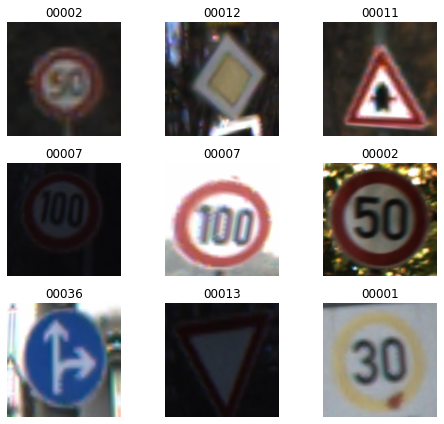

In [6]:
data.show_batch(rows = 3, figsize = (7, 6))

In [7]:
print(data.classes)
print(len(data.classes), data.c)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']
43 43


In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir = 'drive/My Drive/Traffic_Sign/model')
learn.model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.613561,0.287849,0.099235,3:20:31
1,0.198032,0.096469,0.029592,05:41
2,0.093801,0.050687,0.017347,05:39
3,0.074033,0.038431,0.013265,05:32


In [13]:
interpretation = ClassificationInterpretation.from_learner(learn)

losses, idxs = interpretation.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

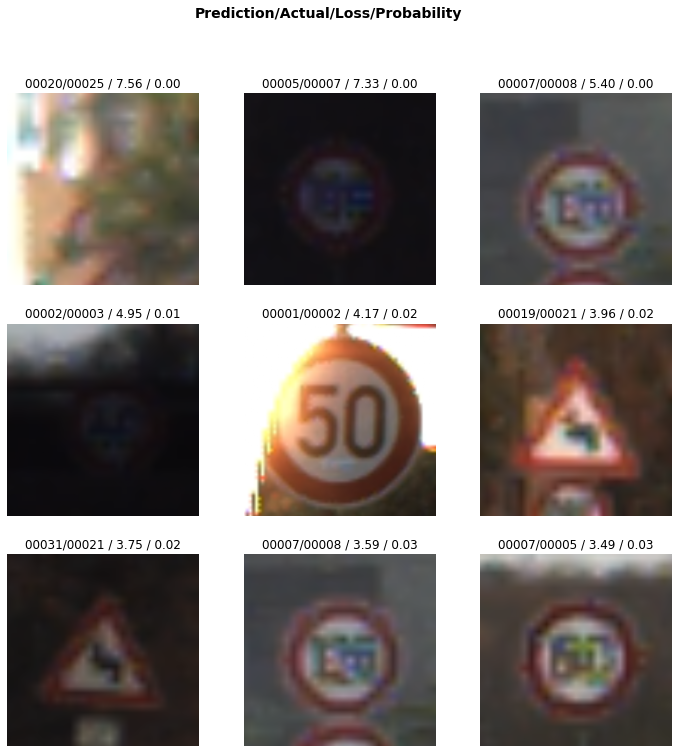

In [14]:
interpretation.plot_top_losses(9)

In [15]:
interpretation.most_confused(min_val = 2)

[('00003', '00005', 5),
 ('00002', '00005', 4),
 ('00008', '00007', 4),
 ('00002', '00001', 3),
 ('00005', '00001', 3),
 ('00001', '00002', 2),
 ('00003', '00002', 2),
 ('00005', '00002', 2),
 ('00005', '00007', 2),
 ('00008', '00005', 2),
 ('00024', '00018', 2)]

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


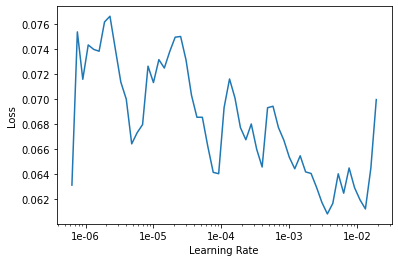

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.033054,0.013175,0.004082,05:47
1,0.011876,0.008439,0.002041,05:55


In [18]:
interpretation = ClassificationInterpretation.from_learner(learn)

losses, idxs = interpretation.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

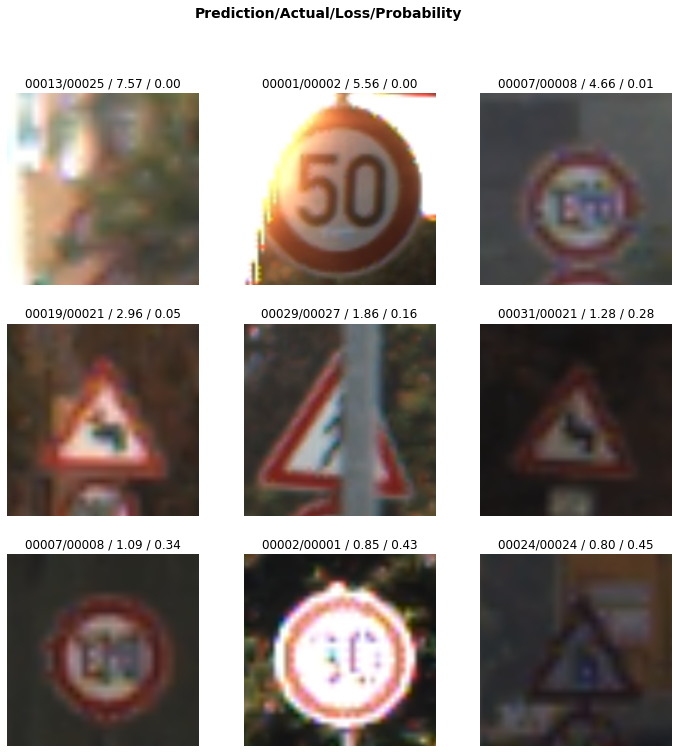

In [19]:
interpretation.plot_top_losses(9)

In [20]:
interpretation.most_confused(min_val=2)

[('00008', '00007', 2)]